# **<span style="color:Yellow;">Scaling, Imputing and Heatmaps with Supervised Learning</span>**

## **Purpose of Notebook**

- Load datasets
- Sample to balance size
- Dummy fill NaNs
- Encode categoricals
- Scale numericals
- Supervised imputation
- Correlation heatmap
- Feature selection (top 10)

---


## **<span style="color:aquamarine;">Load Preprocessed and Cleaned Datasets</span>**

**Load Necessary Libraries**

In [117]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, mean_squared_error
)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tabulate import tabulate
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")


**Load Datasets**


In [118]:
# Display all columns of a pandas DataFrame when printed
pd.set_option('display.max_columns', None)

# US Dataset
US_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US-cleaned_data.csv')
# UK Dataset
UK_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv')

print("US Dataset Shape:", US_data.shape)
print("UK Dataset Shape:", UK_data.shape)

US Dataset Shape: (4372, 21)
UK Dataset Shape: (232365, 21)


**Split the columns**
- Vital to encode the catergorical and datetime columns seperately 
- Useful when trying different imputing methods
- Allows removal on id when needed

In [119]:
# Identify numerical and categorical columns
numerical_columns = ['Posted Speed Limit (MPH)']
categorical_columns = [
    'Make', 'Model', 'Model Year', 'ADS Equipped?',
    'Automation System Engaged?', 'City', 'State', 'Roadway Type', 'Roadway Surface',
    'Lighting', 'Crash With', 'Highest Injury Severity Alleged',
    'SV Pre-Crash Movement', 'SV Contact Area', 'Weather', 'Country'
]
datetime_columns = ['Incident Date', 'Incident Time (24:00)']
indexing_columns = ['Report ID', 'Report Version']


## **<span style="color:aquamarine;">Encode and Scale Values</span>**

**Encoding Function**
- vital for ml models such as regression, KNN, KMeans and heatmaps as catergorical values can be used not just numerical

In [120]:
def encode_df(df, categorical_columns, datetime_columns):
    df_copy = df.copy()

    # Encode categorical columns
    for col in categorical_columns:
        if col in df_copy.columns:
            le = LabelEncoder()
            df_copy[col] = le.fit_transform(df_copy[col].astype(str))
    
    # Encode datetime columns
    for col in datetime_columns:
        if col in df_copy.columns:
            le = LabelEncoder()
            df_copy[col] = le.fit_transform(df_copy[col].astype(str))

    return df_copy

**Scaling Function**
- vital for ml models such as regression, KNN, KMeans and heatmaps as these models work well on unbiased standardised data

In [121]:

def scale_df(df):
    scaler = MinMaxScaler()
    numeric_df = df.select_dtypes(include='number')  # Only numeric columns
    scaled_array = scaler.fit_transform(numeric_df)
    scaled_df = pd.DataFrame(scaled_array, columns=numeric_df.columns, index=df.index)
    return scaled_df


**Encoding and Scaling UK Dataset**


In [122]:
# Create copy and drop indexing cols like ID
UK_data_copy = UK_data.copy()
UK_data_copy.drop(columns=indexing_columns, inplace=True, errors='ignore')
# Encode time and categorical columns
UK_data_encode = encode_df(UK_data_copy, categorical_columns, datetime_columns)
# Scale the numerical features
UK_data_scale = scale_df(UK_data_encode)
# Check encoded data
print(tabulate(UK_data_scale.head(), headers='keys', tablefmt='pretty'))


+---+---------------------------------+----------------------+-----------------------+--------------+--------------------------+----------+---------+-----------------+-----------------------+--------------------+-----------------+---------------------+--------------------+---------+---------------------+---------------------+--------------------+---------------+----------------------------+
|   | Highest Injury Severity Alleged |    Incident Date     | Incident Time (24:00) | Roadway Type | Posted Speed Limit (MPH) | Lighting | Weather | Roadway Surface | SV Pre-Crash Movement |     Crash With     | SV Contact Area |        City         |       State        | Country |        Make         |        Model        |     Model Year     | ADS Equipped? | Automation System Engaged? |
+---+---------------------------------+----------------------+-----------------------+--------------+--------------------------+----------+---------+-----------------+-----------------------+--------------------+

**Encoding and Scaling US Dataset**

In [123]:
# Create copy and drop indexing cols like ID
US_data_copy = US_data.copy()
US_data_copy.drop(columns=indexing_columns, inplace=True, errors='ignore')
# Encode time and categorical columns
US_data_encode = encode_df(US_data_copy, categorical_columns, datetime_columns)
# Scale the numerical features
US_data_scale = scale_df(US_data_encode)
# Check encoded data
print(tabulate(US_data_scale.head(), headers='keys', tablefmt='pretty'))


+---+---------------------+--------------------+--------------------+---------------+----------------------------+----------------------+-----------------------+--------------------+---------------------+--------------------+-----------------+--------------------------+---------------------+--------------------+---------------------------------+-----------------------+---------+--------------------+---------+
|   |        Make         |       Model        |     Model Year     | ADS Equipped? | Automation System Engaged? |    Incident Date     | Incident Time (24:00) |        City        |        State        |    Roadway Type    | Roadway Surface | Posted Speed Limit (MPH) |      Lighting       |     Crash With     | Highest Injury Severity Alleged | SV Pre-Crash Movement | Weather |  SV Contact Area   | Country |
+---+---------------------+--------------------+--------------------+---------------+----------------------------+----------------------+-----------------------+-------------

## **<span style="color:aquamarine;">Imputing Missing Values</span>**
Experimentally, checking the error and precision for each imputing method before choosing the most accurate method which limits skewing.
### Methods of Imputing tried:
- Mean, Median, Mode
- Random 
- Last Occured Carried Forward
- Regression

**Checking how much missing data on both datasets**

In [124]:
def display_missing_values(dataset, dataset_name):
    features_with_na = [feature for feature in dataset.columns if dataset[feature].isnull().sum() > 0]
    
    # Create a PrettyTable
    table = PrettyTable()
    table.field_names = ["Feature", "Percentage of Missing Values"]
    
    for feature in features_with_na:
        missing_percentage = np.round(dataset[feature].isnull().mean() * 100, 2)
        table.add_row([feature, f"{missing_percentage} %"])
    
    print(f"Missing Values in {dataset_name}:")
    print(table)

# Check missing values for both datasets
display_missing_values(UK_data, "UK Dataset")
display_missing_values(US_data, "US Dataset")

Missing Values in UK Dataset:
+---------+------------------------------+
| Feature | Percentage of Missing Values |
+---------+------------------------------+
|  Model  |            1.11 %            |
+---------+------------------------------+
Missing Values in US Dataset:
+--------------------------+------------------------------+
|         Feature          | Percentage of Missing Values |
+--------------------------+------------------------------+
|        Model Year        |            0.32 %            |
|      Incident Date       |            0.43 %            |
|  Incident Time (24:00)   |            4.6 %             |
| Posted Speed Limit (MPH) |           11.34 %            |
+--------------------------+------------------------------+


### **<span style="color:Hotpink;">Mean/Mode Imputer</span>**
- **How it works:** Replaces missing values with the mean (for normally distributed data), or mode (for categorical variables).
- **Best for:** Small amounts of missing numerical data.
- **Limitations:** Can distort distributions and underestimate variance.

In [125]:

# Mean for numerical, Mode for categorical & datetime
def mode_mean_imputation(data, numerical_columns=None, categorical_columns=None, datetime_columns=None):
    data = data.copy()
    numerical_columns = numerical_columns or []
    categorical_columns = categorical_columns or []
    datetime_columns = datetime_columns or []

    for col in numerical_columns:
        if col in data.columns:
            data[col].fillna(data[col].mean(), inplace=True)

    for col in categorical_columns + datetime_columns:
        if col in data.columns:
            mode_val = data[col].mode()
            if not mode_val.empty:
                data[col].fillna(mode_val[0], inplace=True)
    return data


**UK Data**

In [126]:

mode_imputed_df = mode_mean_imputation(UK_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(mode_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+---------------+------------------+-----------------------------------+-----------------+-------------------------+--------------------+----------------------------+----------------+-----------+--------------------+-------------------------+--------------------+-------------------+----------------+----------------+----------------+----------+---------+--------------+-----------------+------------------------------+
|    |     Report ID |   Report Version | Highest Injury Severity Alleged   | Incident Date   | Incident Time (24:00)   | Roadway Type       |   Posted Speed Limit (MPH) | Lighting       | Weather   | Roadway Surface    | SV Pre-Crash Movement   | Crash With         | SV Contact Area   | City           | State          | Country        | Make     | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   |
|----+---------------+------------------+-----------------------------------+-----------------+-------------------------+--------------------+--------

**US Data**

In [127]:

mode_imputed_df = mode_mean_imputation(US_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(mode_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+--------------------+---------+-------------------+-------------------+----------------------------+--------------------+--------------------+-----------------------------------+-------------------------+-----------+--------------------------------+-----------+
|    | Report ID   |   Report Version | Make          | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City               | State   | Roadway Type      | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting           | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area                | Country   |
|----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-

### **<span style="color:Hotpink;">Median Imputer</span>**
- **How it works:** Replaces missing values with the median (for normally distributed data), or mode (for categorical variables).
- **Best for:** Small amounts of missing numerical data.
- **Limitations:** Can distort distributions and underestimate variance.

In [128]:
# Median for numerical, Mode for categorical & datetime
def median_mode_imputation(data, numerical_columns=None, categorical_columns=None, datetime_columns=None):
    data = data.copy()
    numerical_columns = numerical_columns or []
    categorical_columns = categorical_columns or []
    datetime_columns = datetime_columns or []

    for col in numerical_columns:
        if col in data.columns:
            data[col].fillna(data[col].median(), inplace=True)

    for col in categorical_columns + datetime_columns:
        if col in data.columns:
            mode_val = data[col].mode()
            if not mode_val.empty:
                data[col].fillna(mode_val[0], inplace=True)
    return data

**UK Data**

In [129]:

median_imputed_df = median_mode_imputation(UK_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(median_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+---------------+------------------+-----------------------------------+-----------------+-------------------------+--------------------+----------------------------+----------------+-----------+--------------------+-------------------------+--------------------+-------------------+----------------+----------------+----------------+----------+---------+--------------+-----------------+------------------------------+
|    |     Report ID |   Report Version | Highest Injury Severity Alleged   | Incident Date   | Incident Time (24:00)   | Roadway Type       |   Posted Speed Limit (MPH) | Lighting       | Weather   | Roadway Surface    | SV Pre-Crash Movement   | Crash With         | SV Contact Area   | City           | State          | Country        | Make     | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   |
|----+---------------+------------------+-----------------------------------+-----------------+-------------------------+--------------------+--------

**US Data**

In [130]:
median_imputed_df = median_mode_imputation(US_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(median_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+--------------------+---------+-------------------+-------------------+----------------------------+--------------------+--------------------+-----------------------------------+-------------------------+-----------+--------------------------------+-----------+
|    | Report ID   |   Report Version | Make          | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City               | State   | Roadway Type      | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting           | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area                | Country   |
|----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-

### **<span style="color:Hotpink;">Random Imputer</span>**
- **How it works:** Replaces missing by random sampling from existing values  
- **Best for:** Maintaining original distribution with enough data  
- **Limitations:** Adds randomness; may create unrealistic combinations

In [131]:
# Random fill from existing non-missing values
def random_imputation(data, numerical_columns=None, categorical_columns=None, datetime_columns=None):
    data = data.copy()
    numerical_columns = numerical_columns or []
    categorical_columns = categorical_columns or []
    datetime_columns = datetime_columns or []

    for col in numerical_columns + categorical_columns + datetime_columns:
        if col in data.columns:
            non_null_values = data[col].dropna().values
            if data[col].isnull().sum() > 0 and len(non_null_values) > 0:
                random_samples = np.random.choice(non_null_values, size=data[col].isnull().sum(), replace=True)
                data.loc[data[col].isnull(), col] = random_samples
    return data


**UK Data**

In [132]:
mode_imputed_df = random_imputation(UK_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(mode_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+---------------+------------------+-----------------------------------+-----------------+-------------------------+--------------------+----------------------------+----------------+-----------+--------------------+-------------------------+--------------------+-------------------+----------------+----------------+----------------+----------+---------+--------------+-----------------+------------------------------+
|    |     Report ID |   Report Version | Highest Injury Severity Alleged   | Incident Date   | Incident Time (24:00)   | Roadway Type       |   Posted Speed Limit (MPH) | Lighting       | Weather   | Roadway Surface    | SV Pre-Crash Movement   | Crash With         | SV Contact Area   | City           | State          | Country        | Make     | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   |
|----+---------------+------------------+-----------------------------------+-----------------+-------------------------+--------------------+--------

**US Data**

In [133]:
mode_imputed_df = random_imputation(US_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(mode_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+--------------------+---------+-------------------+-------------------+----------------------------+--------------------+--------------------+-----------------------------------+-------------------------+-----------+--------------------------------+-----------+
|    | Report ID   |   Report Version | Make          | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City               | State   | Roadway Type      | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting           | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area                | Country   |
|----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-

### **<span style="color:Hotpink;">Last Occurance Carried Forward (LOCF) Imputer</span>**
- **How it works:** Replaces missing by random sampling from existing values  
- **Best for:** Maintaining original distribution with enough data  
- **Limitations:** Adds randomness; may create unrealistic combinations

In [134]:
# Backward fill for all
def last_occurrence_imputation(data, numerical_columns=None, categorical_columns=None, datetime_columns=None):
    data = data.copy()
    numerical_columns = numerical_columns or []
    categorical_columns = categorical_columns or []
    datetime_columns = datetime_columns or []

    for col in numerical_columns + categorical_columns + datetime_columns:
        if col in data.columns:
            data[col].fillna(method='bfill', inplace=True)
    return data


**UK Data**

In [135]:

# Usage example
mode_imputed_df = last_occurrence_imputation(UK_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(mode_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+---------------+------------------+-----------------------------------+-----------------+-------------------------+--------------------+----------------------------+----------------+-----------+--------------------+-------------------------+--------------------+-------------------+----------------+----------------+----------------+----------+---------+--------------+-----------------+------------------------------+
|    |     Report ID |   Report Version | Highest Injury Severity Alleged   | Incident Date   | Incident Time (24:00)   | Roadway Type       |   Posted Speed Limit (MPH) | Lighting       | Weather   | Roadway Surface    | SV Pre-Crash Movement   | Crash With         | SV Contact Area   | City           | State          | Country        | Make     | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   |
|----+---------------+------------------+-----------------------------------+-----------------+-------------------------+--------------------+--------

**US Data**

In [136]:

# Usage example
mode_imputed_df = last_occurrence_imputation(US_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(mode_imputed_df.head(), headers='keys', tablefmt='psql'))

+----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+--------------------+---------+-------------------+-------------------+----------------------------+--------------------+--------------------+-----------------------------------+-------------------------+-----------+--------------------------------+-----------+
|    | Report ID   |   Report Version | Make          | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City               | State   | Roadway Type      | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting           | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area                | Country   |
|----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-

### **<span style="color:Hotpink;">Regression Imputer</span>**
- **How it works:** Predicts missing values using regression models on other features  
- **Best for:** When strong relationships exist between features  
- **Limitations:** Assumes linearity; risk of overfitting if data is small  

In [137]:

def regression_imputer(df, numerical_columns=None, categorical_columns=None, datetime_columns=None):
    df_copy = df.copy()
    
    if numerical_columns is None:
        numerical_columns = []
    if categorical_columns is None:
        categorical_columns = []
    if datetime_columns is None:
        datetime_columns = []
    
    # Impute numerical columns using IterativeImputer if any numerical columns exist
    if numerical_columns:
        imputer = IterativeImputer(random_state=0)
        imputed_num = imputer.fit_transform(df_copy[numerical_columns])
        imputed_num_df = pd.DataFrame(imputed_num, columns=numerical_columns, index=df_copy.index)
    else:
        imputed_num_df = pd.DataFrame(index=df_copy.index)
    
    # Impute categorical columns using mode if any exist
    if categorical_columns:
        imputed_cat_df = df_copy[categorical_columns].fillna(df_copy[categorical_columns].mode().iloc[0])
    else:
        imputed_cat_df = pd.DataFrame(index=df_copy.index)
    
    # Impute datetime columns using forward fill if any exist
    if datetime_columns:
        imputed_dt_df = df_copy[datetime_columns].fillna(method='ffill')
    else:
        imputed_dt_df = pd.DataFrame(index=df_copy.index)
    
    # Combine all imputed parts (only those with columns)
    imputed_df = pd.concat([df_copy.drop(columns=numerical_columns + categorical_columns + datetime_columns, errors='ignore'),
                            imputed_num_df, imputed_cat_df, imputed_dt_df], axis=1)
    # Optional: reorder columns to match original df
    imputed_df = imputed_df[df_copy.columns]
    
    return imputed_df


**UK Data**

In [138]:
imputed_data = regression_imputer(UK_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(imputed_data.head(), headers="keys", tablefmt="psql"))

+----+---------------+------------------+-----------------------------------+-----------------+-------------------------+--------------------+----------------------------+----------------+-----------+--------------------+-------------------------+--------------------+-------------------+----------------+----------------+----------------+----------+---------+--------------+-----------------+------------------------------+
|    |     Report ID |   Report Version | Highest Injury Severity Alleged   | Incident Date   | Incident Time (24:00)   | Roadway Type       |   Posted Speed Limit (MPH) | Lighting       | Weather   | Roadway Surface    | SV Pre-Crash Movement   | Crash With         | SV Contact Area   | City           | State          | Country        | Make     | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   |
|----+---------------+------------------+-----------------------------------+-----------------+-------------------------+--------------------+--------

**US Data**

In [139]:
imputed_data = regression_imputer(US_data.copy(), numerical_columns, categorical_columns, datetime_columns)
print(tabulate(imputed_data.head(), headers="keys", tablefmt="psql"))

+----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-----------------+-------------------------+--------------------+---------+-------------------+-------------------+----------------------------+--------------------+--------------------+-----------------------------------+-------------------------+-----------+--------------------------------+-----------+
|    | Report ID   |   Report Version | Make          | Model   |   Model Year | ADS Equipped?   | Automation System Engaged?   | Incident Date   | Incident Time (24:00)   | City               | State   | Roadway Type      | Roadway Surface   |   Posted Speed Limit (MPH) | Lighting           | Crash With         | Highest Injury Severity Alleged   | SV Pre-Crash Movement   | Weather   | SV Contact Area                | Country   |
|----+-------------+------------------+---------------+---------+--------------+-----------------+------------------------------+-

### **<span style="color:GreenYellow;">Evaluating: Imputing Methods</span>**
- For each column type trying every single imputing method to see which scores better 

**Support Functions for Imputer Test**

In [140]:

# ---------- helpers ---------- #
def masked_rmse(imputed, original, mask):
    """RMSE only on the cells that were masked *and* successfully imputed."""
    flat_mask = (mask & imputed.notna() & original.notna()).values.flatten()
    if not flat_mask.any():
        return np.nan
    y_true = original.values.flatten()[flat_mask]
    y_pred = imputed.values.flatten()[flat_mask]
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [141]:
def unified_imputer_test(
        data,
        numerical_columns=None,
        categorical_columns=None,
        datetime_columns=None,
        bar_width=0.6,
        figsize=(8, 5),
        rmse_bar_color="#aec6cf", # default pastel blue
        title ="Imputation Error"
):
    numerical_columns = numerical_columns or []
    categorical_columns = categorical_columns or []
    datetime_columns = datetime_columns or []

    selected = numerical_columns + categorical_columns + datetime_columns
    original = data.dropna(subset=selected)[selected].copy()

    # Create a 20% mask
    rng = np.random.default_rng(0)
    mask = pd.DataFrame(rng.random(original.shape) < 0.20,
                        index=original.index, columns=original.columns)
    masked = original.mask(mask)

    # Run imputers
    median_mode = median_mode_imputation(masked.copy(),
                                         numerical_columns, categorical_columns, datetime_columns)
    mode_mean = mode_mean_imputation(masked.copy(),
                                     numerical_columns, categorical_columns, datetime_columns)
    last_occ = last_occurrence_imputation(masked.copy(),
                                         numerical_columns, categorical_columns, datetime_columns)
    random_imp = random_imputation(masked.copy(),
                                  numerical_columns, categorical_columns, datetime_columns)
    regress_imp = regression_imputer(masked.copy(), numerical_columns)  # only numerical

    imputers = {
        "Median‑Mode": median_mode,
        "Mode‑Mean": mode_mean,
        "Last Occur.": last_occ,
        "Random": random_imp,
        "Regression": regress_imp
    }

    # Compute RMSE scores only
    rmse_scores = {}
    for name, df_imp in imputers.items():
        if numerical_columns:
            rmse_scores[name] = masked_rmse(
                df_imp[numerical_columns], original[numerical_columns], mask[numerical_columns])

    # Plot RMSE only
    plt.figure(figsize=figsize)
    if rmse_scores:
        rmses = list(rmse_scores.values())
        labels_rmse = list(rmse_scores.keys())
        bars = plt.bar(labels_rmse, rmses, width=bar_width, color=rmse_bar_color)
        plt.ylabel(f"RMSE {title}")
        plt.title(f"{title}")
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        for b, v in zip(bars, rmses):
            plt.text(b.get_x() + b.get_width() / 2, b.get_height(),
                     f"{v:.3f}", ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    return {"RMSE": rmse_scores}



**Numerical Columns**

UK Numerical Imputing Results


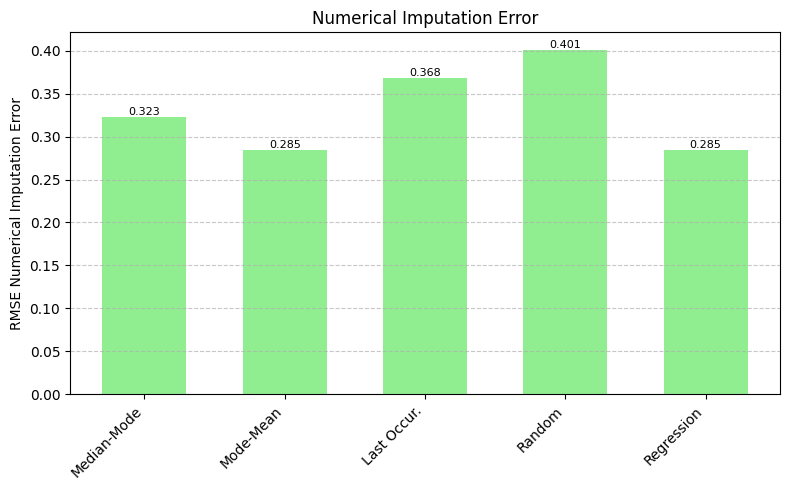

US Numerical Imputing Results


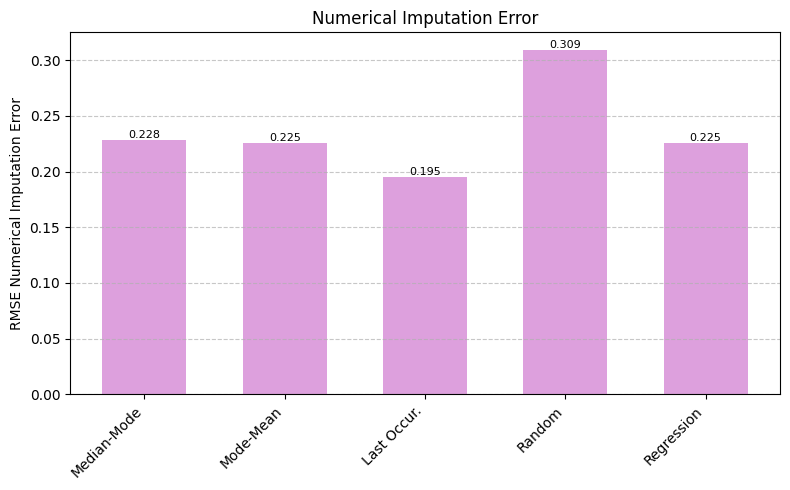

{'RMSE': {'Median‑Mode': 0.22842752228875318,
  'Mode‑Mean': 0.22530125564254685,
  'Last\xa0Occur.': 0.19494007924395984,
  'Random': 0.3094559083543924,
  'Regression': 0.22530125564254685}}

In [142]:
print("UK Numerical Imputing Results")
unified_imputer_test(UK_data_scale, numerical_columns=numerical_columns, rmse_bar_color="lightgreen",title="Numerical Imputation Error")
print("US Numerical Imputing Results")
unified_imputer_test(US_data_scale, numerical_columns=numerical_columns, rmse_bar_color="Plum",title="Numerical Imputation Error")


**Catergorical Columns**

UK Categorical Imputing Results


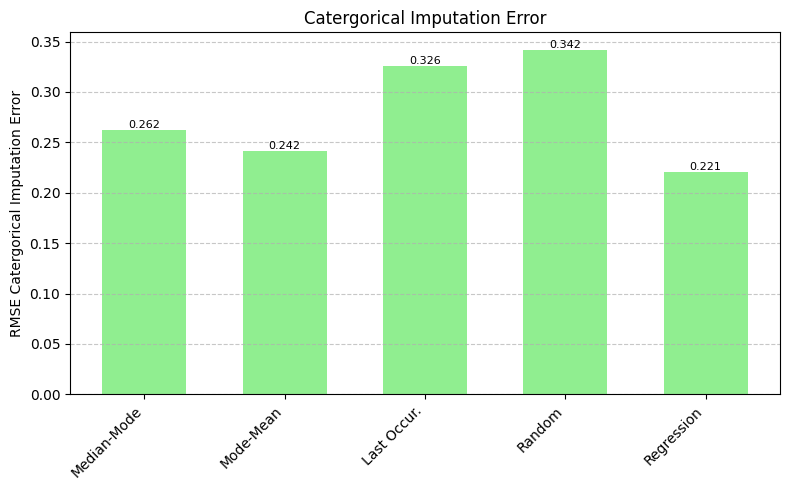

US Categorical Imputing Results


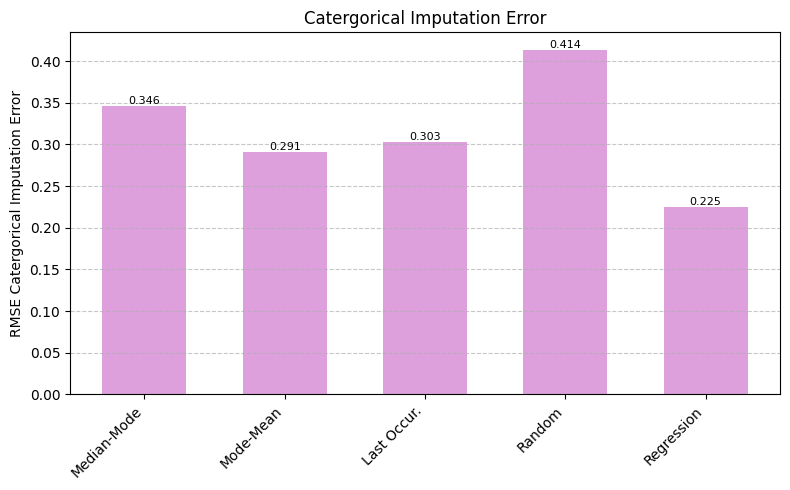

{'RMSE': {'Median‑Mode': 0.34633493010647026,
  'Mode‑Mean': 0.29098523372703333,
  'Last\xa0Occur.': 0.30253967599911463,
  'Random': 0.4138871181279062,
  'Regression': 0.22469816267886414}}

In [143]:
print("UK Categorical Imputing Results")
unified_imputer_test(UK_data_scale, numerical_columns=categorical_columns,rmse_bar_color="lightgreen",title="Catergorical Imputation Error")
print("US Categorical Imputing Results")
unified_imputer_test(US_data_scale, numerical_columns=categorical_columns,rmse_bar_color="Plum",title="Catergorical Imputation Error")

**DateTime Columns**

UK Datetime Imputing Results


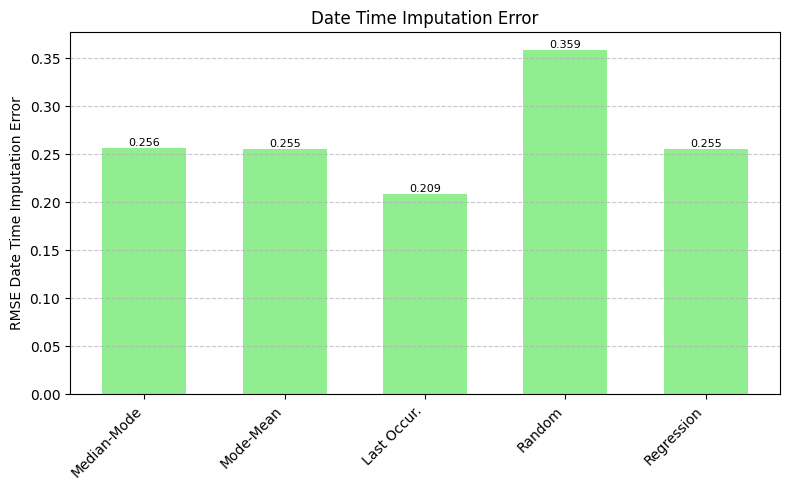

US Datetime Imputing Results


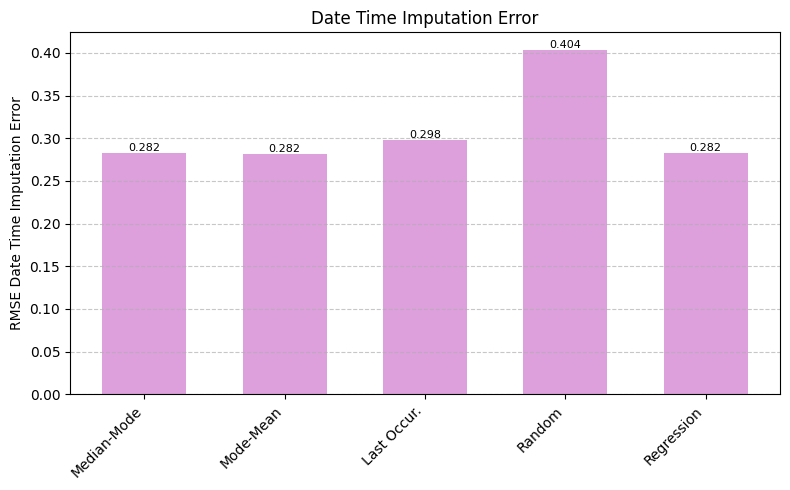

{'RMSE': {'Median‑Mode': 0.28219933409286846,
  'Mode‑Mean': 0.2817960458013529,
  'Last\xa0Occur.': 0.298152833648312,
  'Random': 0.4037928004004259,
  'Regression': 0.282114714405734}}

In [144]:
print("UK Datetime Imputing Results")
unified_imputer_test(UK_data_scale, numerical_columns=datetime_columns,rmse_bar_color="lightgreen",title="Date Time Imputation Error")
print("US Datetime Imputing Results")
unified_imputer_test(US_data_scale, numerical_columns=datetime_columns,rmse_bar_color="Plum",title="Date Time Imputation Error")

**Final Imputation Statergy**
- Last occured for all columns as has the least amount of error